<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Datos
El objecto es utilizar datos disponibles de Anki de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [5]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2025-11-30 23:10:40--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2025-11-30 23:10:40--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0.001s  

2025-11-30 23:10:40 (15.9 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2025-11-30 23:10:40--
Total wall clock time: 0.3s
Downloaded: 1 files, 23K in 0.001s (15.9 MB/s)


In [6]:
def sequence_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=-1,keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1,keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc

def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device), train_decoder_input.to(device))

            # Computo el error de la salida comparando contra las etiquetas
            # por cada token en cada batch (sequence_loss)
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_encoder_input, valid_decoder_input, valid_target = iter(valid_loader).next()
        output = model(valid_encoder_input.to(device), valid_decoder_input.to(device))

        epoch_valid_loss = 0
        for t in range(train_decoder_input.shape[1]):
                epoch_valid_loss += criterion(output[:, t, :], valid_target[:, t, :])
        epoch_valid_loss = epoch_valid_loss.item()

        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = sequence_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### 1 - Datos

In [7]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('spa-eng', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
        output = 'spa-eng.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
To: /content/spa-eng.zip
100%|██████████| 2.64M/2.64M [00:00<00:00, 49.4MB/s]


In [8]:
text_file = "./spa-eng/spa.txt"
with open(text_file, encoding="utf-8") as f:
    lines = f.read().strip().split("\n")

print("Cantidad de filas totales en el archivo:", len(lines))

# Relajamos la restricción para usar más oraciones
MAX_NUM_SENTENCES = 20000

# Mezclar el dataset con semilla fija
np.random.seed(40)
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []

for line in lines:
    if "\t" not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split("\t")

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + " <eos>"
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = "<sos> " + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

    if len(input_sentences) >= MAX_NUM_SENTENCES:
        break

print("Cantidad de rows utilizadas:", len(input_sentences))
print("Ejemplo:")
print("  input :", input_sentences[0])
print("  target:", output_sentences[0])
print("  dec_in:", output_sentences_inputs[0])


Cantidad de filas totales en el archivo: 118964
Cantidad de rows utilizadas: 20000
Ejemplo:
  input : Somebody stole my car.
  target: Alguien robó mi auto. <eos>
  dec_in: <sos> Alguien robó mi auto.


In [9]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('Somebody stole my car.',
 'Alguien robó mi auto. <eos>',
 '<sos> Alguien robó mi auto.')

### 2 - Preprocesamiento

In [10]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [11]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from torch_helpers import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 6812
Sentencia de entrada más larga: 34


In [12]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 11323
Sentencia de salida más larga: 39


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

Longitudes de las oraciones (tokens)
  Input  - min: 1, max: 34, media: 6.34, mediana: 6.00
  Output - min: 1, max: 39, media: 6.94, mediana: 7.00
  Percentil 50% -> input: 6.0 tokens, output: 7.0 tokens
  Percentil 75% -> input: 8.0 tokens, output: 8.0 tokens
  Percentil 90% -> input: 10.0 tokens, output: 10.0 tokens
  Percentil 95% -> input: 11.0 tokens, output: 12.0 tokens
  Percentil 99% -> input: 15.0 tokens, output: 16.0 tokens


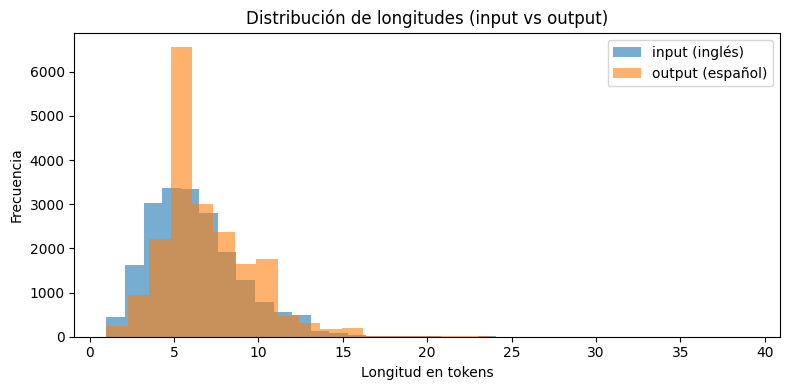

max_input_len elegido (95% de las oraciones): 11
max_out_len elegido (95% de las oraciones): 12


In [13]:
# Longitudes de secuencias en tokens (antes de padding)
input_lengths = np.array([len(seq) for seq in input_integer_seq])
output_lengths = np.array([len(seq) for seq in output_integer_seq])

print("Longitudes de las oraciones (tokens)")
print(f"  Input  - min: {input_lengths.min()}, max: {input_lengths.max()}, "
      f"media: {input_lengths.mean():.2f}, mediana: {np.median(input_lengths):.2f}")
print(f"  Output - min: {output_lengths.min()}, max: {output_lengths.max()}, "
      f"media: {output_lengths.mean():.2f}, mediana: {np.median(output_lengths):.2f}")

for p in [50, 75, 90, 95, 99]:
    in_p = np.percentile(input_lengths, p)
    out_p = np.percentile(output_lengths, p)
    print(f"  Percentil {p:>2}% -> input: {in_p:.1f} tokens, output: {out_p:.1f} tokens")

plt.figure(figsize=(8, 4))
plt.hist(input_lengths, bins=30, alpha=0.6, label="input (inglés)")
plt.hist(output_lengths, bins=30, alpha=0.6, label="output (español)")
plt.xlabel("Longitud en tokens")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitudes (input vs output)")
plt.legend()
plt.tight_layout()
plt.show()

# Elegir nuevas longitudes máximas menos restrictivas usando percentil 95
max_input_len = int(np.percentile(input_lengths, 95))
max_out_len = int(np.percentile(output_lengths, 95))

print(f"max_input_len elegido (95% de las oraciones): {max_input_len}")
print(f"max_out_len elegido (95% de las oraciones): {max_out_len}")


A la hora de realiza padding es importante teneer en cuenta que en el encoder los ceros se agregan al comienoz y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [14]:
import numpy as np

def pad_sequences(
    sequences,
    maxlen,
    dtype="int32",
    padding="pre",
    truncating="pre",
    value=0
):
    """
    Versión simple de pad_sequences compatible con NumPy 2.0.
    Solo cubre el caso de secuencias numéricas (que es lo que usamos acá).
    """
    num_samples = len(sequences)
    x = np.full((num_samples, maxlen), value, dtype=dtype)

    for i, seq in enumerate(sequences):
        if seq is None:
            continue
        seq = list(seq)

        if not len(seq):
            continue

        # Truncar
        if truncating == "pre":
            trunc = seq[-maxlen:]
        elif truncating == "post":
            trunc = seq[:maxlen]
        else:
            raise ValueError("truncating debe ser 'pre' o 'post'")

        trunc = np.asarray(trunc, dtype=dtype)

        # Padding
        if padding == "pre":
            x[i, -len(trunc):] = trunc
        elif padding == "post":
            x[i, :len(trunc)] = trunc
        else:
            raise ValueError("padding debe ser 'pre' o 'post'")

    return x


In [15]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 20000
encoder_input_sequences shape: (20000, 11)
decoder_input_sequences shape: (20000, 12)


In [16]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (20000, 12)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategía que se transformó la entrada del decoder.

In [17]:
torch.from_numpy(decoder_output_sequences).shape

torch.Size([20000, 12])

In [ ]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self,index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len

data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[2]
print("Output dim", output_dim)

In [ ]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)

### 3 - Preparar los embeddings

In [ ]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

In [ ]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [ ]:
# Por una cuestion de RAM se utilizará los embeddings de Glove de dimension 50
model_embeddings = GloveEmbeddings()

In [ ]:
# Crear la Embedding matrix de las secuencias
# en ingles

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

In [ ]:
nb_words

In [ ]:
# Dimensión de los embeddings de la secuencia en ingles
embedding_matrix.shape

### 4 - Entrenar el modelo

In [ ]:
class EncoderBig(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 256          # antes 128
        self.num_layers = 2           # antes 1
        self.embedding_dim = embed_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # congelamos embeddings

        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=0.3 if self.num_layers > 1 else 0.0,
        )

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)


class DecoderBig(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=0.3 if self.num_layers > 1 else 0.0,
        )
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        out = self.softmax(self.fc1(lstm_output[:, -1, :]))  # último paso de la secuencia
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim

        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)

        # En la primera iteracion se toma el primer token de target ()
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random
            # para ver en cada vuelta que técnica se aplica
            #input = top1

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs


In [ ]:
encoder_big = EncoderBig(vocab_size=nb_words)
decoder_big = DecoderBig(vocab_size=num_words_output, output_dim=num_words_output)

if cuda:
    encoder_big.cuda()
    decoder_big.cuda()

model_big = Seq2Seq(encoder_big, decoder_big)
if cuda:
    model_big.cuda()

optimizer_big = torch.optim.Adam(model_big.parameters(), lr=0.001)  # lr más chico para modelo más grande
criterion = torch.nn.CrossEntropyLoss()

summary(model_big, input_data=(data_set[0:1][0], data_set[0:1][1]))

In [ ]:
history_big = train(
    model_big,
    train_loader,
    valid_loader,
    optimizer_big,
    criterion,
    epochs=15   # algunas épocas más para el modelo grande
)

In [ ]:
epoch_count = range(1, len(history_big['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history_big['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history_big['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [ ]:
# Conversores de índice a palabra
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v: k for k, v in word2idx_outputs.items()}

device = torch.device("cuda" if cuda else "cpu")

def translate_sentence(model, sentence, max_len=max_out_len):
    model.eval()

    # Texto → ids
    integer_seq = input_tokenizer.texts_to_sequences([sentence])[0]
    encoder_seq = pad_sequences([integer_seq], maxlen=max_input_len)
    encoder_tensor = torch.from_numpy(encoder_seq.astype(np.int32)).to(device)

    # Estado inicial del decoder desde el encoder
    prev_state = model.encoder(encoder_tensor)

    # Token inicial <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs["<sos>"]
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32)).to(device)

    eos = word2idx_outputs["<eos>"]
    output_sentence = []

    for _ in range(max_len):
        output, prev_state = model.decoder(target_seq_tensor, prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        if idx == eos:
            break

        if idx > 0:
            word = idx2word_target.get(idx, "")
            if word:
                output_sentence.append(word)

        # re-alimentar el token predicho
        target_seq_tensor = top1.to(device)

    return " ".join(output_sentence)


In [ ]:
# Ejemplos manuales
test_sentences = [
    "How are you?",
    "My mother says hi.",
    "I like to learn machine learning.",
    "This restaurant is very good.",
    "I will call you tomorrow."
]

print("=== Traducciones (modelo grande) ===")
for s in test_sentences:
    print("-" * 50)
    print("EN:", s)
    print("ES:", translate_sentence(model_big, s))

# Ejemplos tomados del dataset (para comparar con la referencia)
print("\n=== Ejemplos del dataset ===")
for _ in range(5):
    i = np.random.randint(len(input_sentences))
    src = input_sentences[i]
    tgt = output_sentences[i]
    pred = translate_sentence(model_big, src)
    print("-" * 50)
    print("EN      :", src)
    print("ES real :", tgt)
    print("ES pred :", pred)
